### **MNIST Digit Classification: MLP vs. MLP with Attention**
#### Deep Learning Experimentation Notebook

This notebook explores the architectural differences and performance trade-offs between a traditional **Multi-Layer Perceptron (MLP)** and an **MLP with a Spatial Attention Mechanism**. 

The experiment is conducted across two distinct scenarios:
1.  **Standard MNIST:** $28 \times 28$ centered digits.
2.  **Hard MNIST:** $56 \times 56$ noisy canvas with digits placed at random spatial coordinates.

# Hard MNIST: The Case for Attention

To see Attention truly shine, we have to move away from the "perfect" conditions of standard MNIST. Attention is designed to handle **spatial variation and distraction**—challenges that traditional architectures struggle to overcome.

### The "Hard MNIST" Scenario
Instead of a centered 28x28 image, we use a **56x56 canvas**. The original digit is placed in a **random corner**, and the remaining area is filled with **random Gaussian noise**.



---

## Why the Plain MLP Fails
A standard Multi-Layer Perceptron (MLP) is structurally "rigid." It fails in this scenario for three main reasons:

* **Fixed Coordinate Mapping:** The MLP tries to learn a fixed weight for every single pixel coordinate. If the "learned" weights for the center are now looking at empty space or noise, the model fails.
* **Lack of Translation Invariance:** It cannot recognize that a "7" in the top-left is the same as a "7" in the bottom-right because it sees them as entirely different input features.
* **Sensitivity to Noise:** Without a way to filter input, the MLP processes the random noise with the same priority as the digit, leading to high error rates.

---

## Why Attention Wins
The Attention Mechanism acts as a **dynamic filter**, allowing the model to "perceive" the canvas rather than just "read" it.

* **Active Scanning:** The mechanism learns to "scan" the canvas. It identifies the cluster of pixels that matches the internal representation of a digit.
* **The "Soft Crop":** Once the digit is found, Attention effectively "crops" the focus of the network onto that specific area, assigning near-zero importance to the noise everywhere else.
* **Spatial Independence:** Because Attention looks for **features** (shapes and edges) rather than **coordinates**, it remains highly accurate regardless of where the digit is hidden on the canvas.



> **The takeaway:** While an MLP is a static template, Attention is a searchlight. It ignores the "where" to focus on the "what."

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf

# Enable eager execution explicitly
tf.config.run_functions_eagerly(True)

from tensorflow.keras import layers, models, callbacks

/home/jaumemanero/RL/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# We try two attention approaches

def build_spatial_soft_attention_JAU():
    """
    Alternative: Spatial attention with proper information flow
    Uses 2D structure for better spatial reasoning
    """
    inputs = layers.Input(shape=(56, 56))
    x_reshaped = layers.Reshape((56, 56, 1))(inputs)
    
    # Learn spatial attention map at lower resolution for efficiency
    # Downsample to 28x28
    att_map = layers.AveragePooling2D(pool_size=(2, 2))(x_reshaped)
    att_map = layers.Conv2D(16, 3, activation='relu', padding='same')(att_map)
    att_map = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(att_map)
    
    # Upsample attention map back to 56x56
    att_map = layers.UpSampling2D(size=(2, 2))(att_map)
    att_map = layers.Flatten()(att_map)
    
    # Apply attention to enhance relevant regions
    flat = layers.Flatten()(inputs)
    
    # Weighted combination: (1-α)*original + α*attended
    # This ensures original information is never completely blocked
    attended = layers.Multiply()([flat, att_map])
    
    # Mix attended and original features
    alpha = 0.7  # 70% attended, 30% original
    # In practice, we'll learn this mixing through the network
    
    # Process both streams
    attended_stream = layers.Dense(512, activation='relu')(attended)
    attended_stream = layers.Dense(256, activation='relu')(attended_stream)
    
    direct_stream = layers.Dense(512, activation='relu')(flat)
    direct_stream = layers.Dense(256, activation='relu')(direct_stream)
    
    # Learnable fusion
    combined = layers.Concatenate()([attended_stream, direct_stream])
    
    # Classification head
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    outputs = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

def build_soft_attention_mlp_JAU():
    """
    Soft attention that enhances rather than blocks information.
    Key differences from bottleneck:
    1. Attention is ADDITIVE, not multiplicative bottleneck
    2. Multiple attention heads for redundancy
    3. Skip connection preserves original information
    """
    inputs = layers.Input(shape=(56, 56))
    flat = layers.Flatten()(inputs)
    
    # Multi-head soft attention
    num_heads = 3
    attended_features = []
    
    for i in range(num_heads):
        # Each head learns to focus on different patterns
        attention_weights = layers.Dense(512, activation='relu', 
                                        name=f'att_head_{i}_1')(flat)
        attention_weights = layers.Dense(3136, activation='softmax',
                                        name=f'att_head_{i}_2')(attention_weights)
        
        # Apply attention - this enhances relevant pixels
        attended = layers.Multiply(name=f'att_multiply_{i}')([flat, attention_weights])
        
        # Process attended features
        features = layers.Dense(256, activation='relu', 
                               name=f'att_process_{i}')(attended)
        attended_features.append(features)
    
    # Combine all attention heads
    if len(attended_features) > 1:
        combined_attention = layers.Concatenate()(attended_features)
    else:
        combined_attention = attended_features[0]
    
    # CRITICAL: Also process the original input (skip connection)
    # This ensures we don't lose information through attention
    direct_features = layers.Dense(512, activation='relu', 
                                   name='direct_process_1')(flat)
    direct_features = layers.Dense(256, activation='relu',
                                   name='direct_process_2')(direct_features)
    
    # Combine attended features with direct features
    combined = layers.Concatenate()([combined_attention, direct_features])
    
    # Final classification layers
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    outputs = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [3]:
# Models definition

def create_hard_mnist(x):
    """Create Hard-MNIST by randomly placing digits on a noisy canvas"""
    canvas = np.random.normal(0, 0.1, (len(x), 56, 56))
    for i in range(len(x)):
        r = np.random.randint(0, 29)
        c = np.random.randint(0, 29)
        canvas[i, r:r+28, c:c+28] = x[i]
    return canvas

def build_plain_mlp():
    """Simple baseline MLP with more dropout to reduce overfitting"""
    inputs = layers.Input(shape=(56, 56))
    flat = layers.Flatten()(inputs)
    
    x = layers.Dense(512, activation='relu')(flat)
    x = layers.Dropout(0.5)(x)  # Increased dropout
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Added dropout
    outputs = layers.Dense(10, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)


    
# CALLBACKS

def get_training_callbacks():
    """Set up callbacks for better training"""
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # More patience
        min_lr=1e-6,
        verbose=1
    )
    
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Much more patience - let it train longer
        restore_best_weights=False,
        verbose=1
    )
    
    return [reduce_lr, early_stop]

In [4]:
# Load data

print("Loading MNIST data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

# Create hard MNIST
print("Creating Hard-MNIST...")
x_train_hard = create_hard_mnist(x_train)
x_test_hard = create_hard_mnist(x_test)

print(f"Training data shape: {x_train_hard.shape}")
print(f"Test data shape: {x_test_hard.shape}")

Loading MNIST data...
Creating Hard-MNIST...
Training data shape: (60000, 56, 56)
Test data shape: (10000, 56, 56)


In [5]:
# Build models
print("\n" + "="*60)
print("Building Plain MLP...")
print("="*60)
model_plain = build_plain_mlp()
model_plain.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(model_plain.summary())


Building Plain MLP...


2026-01-06 17:02:52.288369: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 56, 56)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,771,658 (6.76 MB)

 Trainable params: 1,771,658 (6.76 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
print("\n" + "="*60)
print("Building Soft Attention MLP...")
print("="*60)
model_attention = build_soft_attention_mlp_JAU()
model_attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(model_attention.summary())

print("\nNote: Models will be rebuilt fresh before each training to avoid session conflicts")


Building Soft Attention MLP...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 56, 56)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_0_1        │ (None, 512)       │  1,606,144 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_1_1        │ (None, 512)       │  1,606,144 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_2_1        │ (None, 512)       │  1,606,144 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_0_2        │ (None, 3136)      │  1,608,768 │ att_head_0_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_1_2        │ (None, 3136)      │  1,608,768 │ att_head_1_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_head_2_2        │ (None, 3136)      │  1,608,768 │ att_head_2_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_multiply_0      │ (None, 3136)      │          0 │ flatten_1[0][0],  │
│ (Multiply)          │                   │            │ att_head_0_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_multiply_1      │ (None, 3136)      │          0 │ flatten_1[0][0],  │
│ (Multiply)          │                   │            │ att_head_1_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_multiply_2      │ (None, 3136)      │          0 │ flatten_1[0][0],  │
│ (Multiply)          │                   │            │ att_head_2_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_process_0       │ (None, 256)       │    803,072 │ att_multiply_0[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_process_1       │ (None, 256)       │    803,072 │ att_multiply_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_process_2       │ (None, 256)       │    803,072 │ att_multiply_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direct_process_1    │ (None, 512)       │  1,606,144 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ att_process_0[0]… │
│ (Concatenate)       │                   │            │ att_process_1[0]… │
│                     │                   │            │ att_process_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direct_process_2    │ (None, 256)       │    131,328 │ direct_process_1

 Total params: 14,481,738 (55.24 MB)

 Trainable params: 14,481,738 (55.24 MB)

 Non-trainable params: 0 (0.00 B)

None

Note: Models will be rebuilt fresh before each training to avoid session conflicts


In [7]:
print("\n" + "="*60)
print("Building Spatial Soft Attention MLP...")
print("="*60)
model_attention = build_spatial_soft_attention_JAU()
model_attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(model_attention.summary())

print("\nNote: Models will be rebuilt fresh before each training to avoid session conflicts")


Building Spatial Soft Attention MLP...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 56, 56)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 56, 56, 1) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 28, 28, 1) │          0 │ reshape[0][0]     │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        160 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28, 1) │         17 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56, 1) │          0 │ conv2d_1[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3136)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 3136)      │          0 │ flatten_3[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  1,606,144 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  1,606,144 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │    262,656 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │      1,290 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,903,291 (14.89 MB)

 Trainable params: 3,903,291 (14.89 MB)

 Non-trainable params: 0 (0.00 B)

None

Note: Models will be rebuilt fresh before each training to avoid session conflicts


In [8]:
%%time
# Train Plain MLP
print("\n" + "="*60)
print("Training Plain MLP...")
print("="*60)

# Create fresh model for plain MLP
model_plain_fresh = build_plain_mlp()
model_plain_fresh.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_plain = model_plain_fresh.fit(
    x_train_hard, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.3,
    callbacks=get_training_callbacks(),
    verbose=1
)

# Evaluate plain MLP
test_loss_plain, test_acc_plain = model_plain_fresh.evaluate(x_test_hard, y_test, verbose=0)


Training Plain MLP...


/home/jaumemanero/RL/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.2097 - loss: 2.1239 - val_accuracy: 0.3859 - val_loss: 1.7543 - learning_rate: 0.0010
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4025 - loss: 1.6225 - val_accuracy: 0.5754 - val_loss: 1.2608 - learning_rate: 0.0010
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5491 - loss: 1.2361 - val_accuracy: 0.6738 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6412 - loss: 0.9917 - val_accuracy: 0.7230 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7082 - loss: 0.8228 - val_accuracy: 0.7479 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.7528 - loss: 0.7041 - val_accuracy: 0.7641 - val_loss: 0.7279 - learning_rate: 0.0010
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7900 - l

In [9]:
%%time
# Clean up and prepare for next model - Soft Attention
tf.keras.backend.clear_session()
import gc
gc.collect()

# Train Attention MLP
print("\n" + "="*60)
print("Training Soft Attention MLP...")
print("="*60)

# Create fresh model for attention MLP
model_attention_soft = build_soft_attention_mlp_JAU()
model_attention_soft.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_attention_soft = model_attention_soft.fit(
    x_train_hard, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.3,
    callbacks=get_training_callbacks(),
    verbose=1
)

# Evaluate attention MLP
test_loss_attention_soft, test_acc_attention_soft = model_attention_soft.evaluate(x_test_hard, y_test, verbose=0)


Training Soft Attention MLP...
Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 71s 215ms/step - accuracy: 0.3540 - loss: 1.7404 - val_accuracy: 0.5898 - val_loss: 1.1108 - learning_rate: 0.0010
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 70s 212ms/step - accuracy: 0.7040 - loss: 0.8367 - val_accuracy: 0.7310 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.8435 - loss: 0.4525 - val_accuracy: 0.7604 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.9151 - loss: 0.2559 - val_accuracy: 0.7791 - val_loss: 0.7805 - learning_rate: 0.0010
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.9489 - loss: 0.1614 - val_accuracy: 0.7749 - val_loss: 0.8571 - learning_rate: 0.0010
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.9639 - loss: 0.1153 - val_accuracy: 0.7911 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━

In [10]:
%%time
# Clean up and prepare for next model - Spatial Attention
tf.keras.backend.clear_session()
import gc
gc.collect()

# Train Attention MLP
print("\n" + "="*60)
print("Training Soft Attention MLP...")
print("="*60)

# Create fresh model for attention MLP
model_attention_spatial = build_spatial_soft_attention_JAU()
model_attention_spatial.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_attention_spatial = model_attention_spatial.fit(
    x_train_hard, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.3,
    callbacks=get_training_callbacks(),
    verbose=1
)

# Evaluate attention MLP
test_loss_attention_spatial, test_acc_attention_spatial = model_attention_spatial.evaluate(x_test_hard, y_test, verbose=0)


Training Soft Attention MLP...
Epoch 1/50
  1/329 ━━━━━━━━━━━━━━━━━━━━ 1:29 272ms/step - accuracy: 0.0938 - loss: 2.3032

2026-01-06 17:30:27.391759: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - accuracy: 0.3641 - loss: 1.6937 - val_accuracy: 0.6339 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.7396 - loss: 0.7361 - val_accuracy: 0.7862 - val_loss: 0.6234 - learning_rate: 0.0010
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.8897 - loss: 0.3382 - val_accuracy: 0.8213 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.9433 - loss: 0.1798 - val_accuracy: 0.8221 - val_loss: 0.6485 - learning_rate: 0.0010
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - accuracy: 0.9616 - loss: 0.1194 - val_accuracy: 0.8243 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9725 - loss: 0.0907 - val_accuracy: 0.8328 - val_loss: 0.7394 - learning_rate: 0.0010
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9785 - loss:

In [11]:
# Evaluate  models
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\nPlain MLP:")
print(f"  Test Accuracy: {test_acc_plain:.4f}")
print(f"  Test Loss: {test_loss_plain:.4f}")

print(f"\nAttention Soft MLP:")
print(f"  Test Accuracy: {test_acc_attention_soft:.4f}")
print(f"  Test Loss: {test_loss_attention_soft:.4f}")

print(f"\nAttention Spatial MLP:")
print(f"  Test Accuracy: {test_acc_attention_spatial:.4f}")
print(f"  Test Loss: {test_loss_attention_spatial:.4f}")



EVALUATION RESULTS

Plain MLP:
  Test Accuracy: 0.8159
  Test Loss: 0.7406

Attention Soft MLP:
  Test Accuracy: 0.8225
  Test Loss: 1.2745

Attention Spatial MLP:
  Test Accuracy: 0.8672
  Test Loss: 0.8881


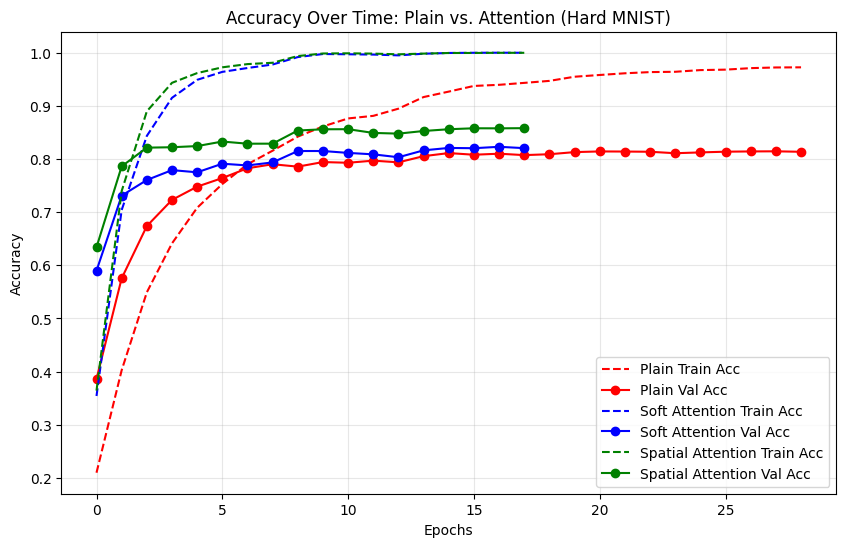

In [12]:
# Comparison Plot for Hard MNIST
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot Plain MLP Accuracy (Red)
plt.plot(history_plain.history['accuracy'], label='Plain Train Acc', color='red', linestyle='--')
plt.plot(history_plain.history['val_accuracy'], label='Plain Val Acc', color='red', marker='o')

# Plot Attention MLP Accuracy (Blue)
plt.plot(history_attention_soft.history['accuracy'], label='Soft Attention Train Acc', color='blue', linestyle='--')
plt.plot(history_attention_soft.history['val_accuracy'], label='Soft Attention Val Acc', color='blue', marker='o')

plt.plot(history_attention_spatial.history['accuracy'], label='Spatial Attention Train Acc', color='green', linestyle='--')
plt.plot(history_attention_spatial.history['val_accuracy'], label='Spatial Attention Val Acc', color='green', marker='o')

plt.title('Accuracy Over Time: Plain vs. Attention (Hard MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

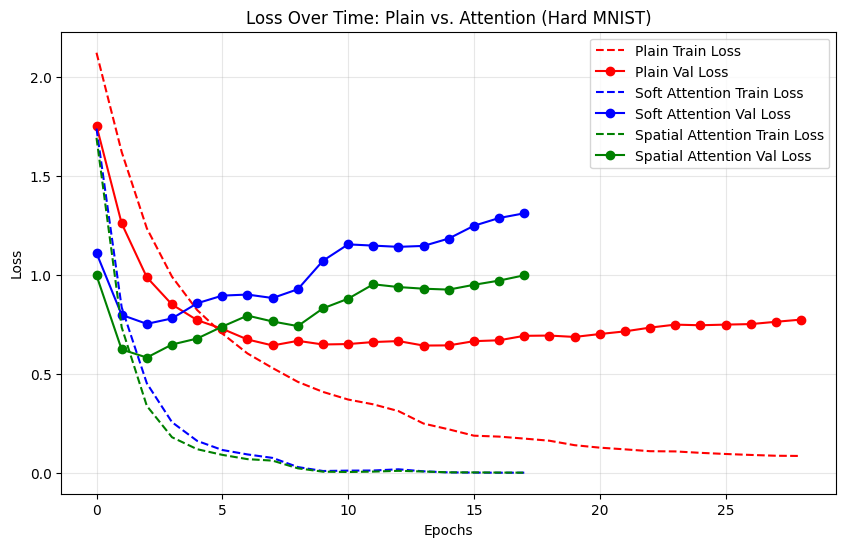

In [13]:
plt.figure(figsize=(10, 6))

# Plot Plain MLP Loss (Red)
plt.plot(history_plain.history['loss'], label='Plain Train Loss', color='red', linestyle='--')
plt.plot(history_plain.history['val_loss'], label='Plain Val Loss', color='red', marker='o')

# Plot Soft Attention MLP Loss (Blue)
plt.plot(history_attention_soft.history['loss'], label='Soft Attention Train Loss', color='blue', linestyle='--')
plt.plot(history_attention_soft.history['val_loss'], label='Soft Attention Val Loss', color='blue', marker='o')

# Plot Spatial Attention MLP Loss (Green)
plt.plot(history_attention_spatial.history['loss'], label='Spatial Attention Train Loss', color='green', linestyle='--')
plt.plot(history_attention_spatial.history['val_loss'], label='Spatial Attention Val Loss', color='green', marker='o')

plt.title('Loss Over Time: Plain vs. Attention (Hard MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()